In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# source https://www.kaggle.com/thefc17/bundesliga-results-19932018/version/1
bl = pd.read_csv('Bundesliga_Results.csv', parse_dates=['Date'])

This dataset contains results from every Bundesliga match from 1993-1994 to 2017-2018. It also includes half time results, but only from 1995-96 to 2017-18. Columns include Division (denoted as D1), HomeTeam, AwayTeam, FTHG (final time home goals), FTAG (final time away goals), FTR (full time result), HTHG (half time home goals), HTAG (half time away goals), HTR (half time result), and season.

Data compiled into one file from this site: http://www.football-data.co.uk/germanym.php

In [3]:
bl.sort_values(by='Date', inplace=True)
bl.HomeTeam = bl.HomeTeam.apply(lambda x: x.lower().replace(' ', ''))
bl.AwayTeam = bl.AwayTeam.apply(lambda x: x.lower().replace(' ', ''))
# add draws to the winner, doesn't really matter
bl['home_win'] = np.where(bl.FTHG >= bl.FTAG, 1, 0)
bl['draw'] = np.where(bl.FTHG==bl.FTAG, 1, 0)
bl['away_win'] = np.where(bl.FTHG < bl.FTAG, 1, 0)
bl['winner'] = (bl.HomeTeam * (bl.home_win) + bl.AwayTeam * bl.away_win)
bl['loser'] = (bl.HomeTeam * (1 - bl.home_win) + bl.AwayTeam * (1 - bl.away_win))

print('Dataset contains {} matches from {} to {}. Home won {} ({}%). There were {} draws ({}%).'.format(len(bl), bl.Date.min().date(), bl.Date.max().date(), bl.home_win.sum(), int(100*bl.home_win.sum()/len(bl)), bl.draw.sum(), int(100*bl.draw.sum()/len(bl)) ))

Dataset contains 7650 matches from 1993-01-09 to 2018-12-05. Home won 5551 (72%). There were 1964 draws (25%).


In [4]:
def get_matchup(row):
    if row.FTHG >= row.FTAG:
        winner_is_home = True
    else:
        winner_is_home = False
    if row.FTHG == row.FTAG:
        draw = True
    else:
        draw = False
    return (winner_is_home, draw)

In [5]:
bl.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season,home_win,draw,away_win,winner,loser
44,D1,1993-01-09,werderbremen,duisburg,1,5,A,NaN,NaN,NaN,1993-94,0,0,1,duisburg,werderbremen
42,D1,1993-01-09,m'gladbach,schalke04,3,2,H,NaN,NaN,NaN,1993-94,1,0,0,m'gladbach,schalke04
41,D1,1993-01-09,kaiserslautern,nurnberg,3,1,H,NaN,NaN,NaN,1993-94,1,0,0,kaiserslautern,nurnberg
40,D1,1993-01-09,hamburg,leverkusen,2,1,H,NaN,NaN,NaN,1993-94,1,0,0,hamburg,leverkusen
39,D1,1993-01-09,fckoln,freiburg,2,0,H,NaN,NaN,NaN,1993-94,1,0,0,fckoln,freiburg


In [6]:
teams = list(set(list(bl.winner.values) + list(bl.loser.values)))

In [7]:
seasons = bl.Season.unique()
seasons

array(['1993-94', '1994-95', '1995-96', '1996-97', '1997-98', '1998-99',
       '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05',
       '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11',
       '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17',
       '2017-18'], dtype=object)

In [8]:
from elo import Elo as ELO
from glicko2 import Glicko2 as GLICKO
import trueskill as ts
from collections import defaultdict

In [9]:
Elo = ELO()
Glicko = GLICKO()

In [10]:
# default values
elo_ratings = defaultdict(list)
gl_ratings = defaultdict(list)
ts_ratings = defaultdict(list)
match_dates = defaultdict(list)

for team in teams:
    elo_ratings[team].append(Elo.create_rating())
    gl_ratings[team].append(Glicko.create_rating())
    ts_ratings[team].append(ts.Rating())        

In [11]:
def update_elo_ratings(winner, loser, draw):
    winner_rating = elo_ratings[winner][-1]
    loser_rating = elo_ratings[loser][-1]
    winner_rating_new, loser_rating_new = Elo.rate_1vs1(winner_rating, loser_rating, drawn=draw)
    elo_ratings[winner].append(winner_rating_new)
    elo_ratings[loser].append(loser_rating_new)
    return winner_rating_new, loser_rating_new

In [12]:
def update_glicko_ratings(winner, loser, draw):
    winner_rating = gl_ratings[winner][-1]
    loser_rating = gl_ratings[loser][-1]
    winner_rating_new, loser_rating_new = Glicko.rate_1vs1(winner_rating, loser_rating, drawn=draw)
    gl_ratings[winner].append(winner_rating_new)
    gl_ratings[loser].append(loser_rating_new)
    return winner_rating_new, loser_rating_new

In [13]:
def update_ts_ratings(winner, loser, draw):
    winner_rating = ts_ratings[winner][-1]
    loser_rating = ts_ratings[loser][-1]
    winner_rating_new, loser_rating_new = ts.rate_1vs1(winner_rating, loser_rating, drawn=draw)
    ts_ratings[winner].append(winner_rating_new)
    ts_ratings[loser].append(loser_rating_new)
    return winner_rating_new, loser_rating_new

In [14]:
for idx, row in bl.iterrows():
    
    match_dates[row.HomeTeam].append(row.Date)
    match_dates[row.AwayTeam].append(row.Date)
    
    winner_is_home, draw = get_matchup(row)
    if winner_is_home:
        winner = row.HomeTeam
        loser = row.AwayTeam
    else:
        winner = row.AwayTeam
        loser = row.HomeTeam
    wr, lr = update_elo_ratings(winner, loser, draw)
    wr, lr = update_glicko_ratings(winner, loser, draw)
    wr, lr = update_ts_ratings(winner, loser, draw)

In [ ]:
# todo: change k to 32/64

In [64]:
def normalize(ratings):
    return (ratings - ratings.min()) / (ratings.max() - ratings.min())

def apply_confidence_glicko(glicko_rating):
    skill = []
    for r in glicko_rating:
        skill.append(r.mu - 2*r.phi)
    return np.array(skill)

def apply_confidence_ts(ts_rating):
    skill = []
    for r in ts_rating:
        skill.append(r.mu - 2*r.sigma)
    return np.array(skill)

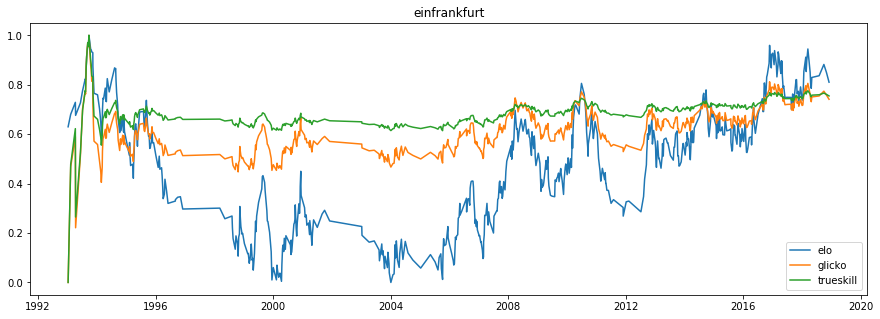

In [67]:
team = 'einfrankfurt'
plt.figure(figsize=(15,5))
plt.plot(match_dates[team], normalize(np.array(elo_ratings[team][1:])), label='elo')
plt.plot(match_dates[team], normalize(apply_confidence_glicko(gl_ratings[team][1:])), label='glicko')
plt.plot(match_dates[team], normalize(apply_confidence_ts(ts_ratings[team][1:])), label='trueskill')
plt.legend()
_ = plt.title(team)

In [73]:
gr = defaultdict(list)
for t in ['a', 'b', 'c', 'd', 'e', 'f']:
    gr[t].append(Glicko.create_rating())

In [69]:
for matchup in [('a', 'b'), ('c', 'd'), ('e', 'f'), ('b', 'c'), ('d', 'e')]:
    winner_rating_new, loser_rating_new = Glicko.rate_1vs1(gr[matchup[0]][-1], gr[matchup[1]][-1], drawn=False)
    gr[matchup[0]].append(winner_rating_new)
    gr[matchup[1]].append(loser_rating_new)

In [72]:
for t, ratings in gr.items():
    print (t, apply_confidence_glicko(ratings))

a [ 800.         1081.67429249]
b [ 800.          757.05586739 1045.9645849 ]
c [ 800.         1081.67429249  912.08908194]
d [ 800.          757.05586739 1045.9645849 ]
e [ 800.         1081.67429249  912.08908194]
f [800.         757.05586739]


In [76]:
Glicko.rate(gr['a'][-1], [(1, gr['b'][-1])])

glicko2.Rating(mu=1662.309, phi=290.317, sigma=0.060)

In [77]:
Glicko.rate(gr['b'][-1], [(0, gr['a'][-1]), (1, gr['b'][-1])])

glicko2.Rating(mu=1500.000, phi=253.403, sigma=0.060)

In [78]:
Glicko.rate(gr['c'][-1], [(1, gr['d'][-1]), (0, gr['b'][-1])])

glicko2.Rating(mu=1500.000, phi=253.403, sigma=0.060)